In [1]:
import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

print(cifar.keys())

pixels = cifar['pixels']
overfeat = cifar['overfeat']
labels = cifar['labels']
names = cifar['names']

print('pixels shape :',pixels.shape, ', dtype:', pixels.dtype)
print('overfeat shape :',overfeat.shape, ', dtype:', overfeat.dtype)
print('labels shape :',labels.shape, ', dtype:', labels.dtype)
print('Categories:', names)

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])
pixels shape : (5000, 3072) , dtype: uint8
overfeat shape : (5000, 4096) , dtype: float32
labels shape : (5000,) , dtype: int64
Categories: ['truck' 'car' 'airplane' 'ship']


In [2]:
# split the Overfeat data into train/test sets w/ same proportion of classes in each subset

import pandas as pd
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    overfeat, labels, train_size=4000, test_size=1000, 
    stratify=labels , # same class distribution
    random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)
print('class distribution in train set:','\n', pd.value_counts(y_tr, normalize=True))
print('class distribution in test set:','\n', pd.value_counts(y_te, normalize=True))

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


In [3]:
# Then, split the train set (4,000 points) into a (smaller) train and validation sets
# with respectively 3,200 and 800 samples

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)
print('Class distribution in train set:','\n',pd.value_counts(y_tr2, normalize=True))
print('Class distribution in test set:','\n', pd.value_counts(y_val, normalize=True))

Train2: (3200, 4096) (3200,)
Val: (800, 4096) (800,)
Class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
Class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


### Decision tree classifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create decision tree classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization
    ('pca', PCA(n_components=172)), # PCA preprocessing, number of components to retain 90% of the variance explained.
    ('dt', DecisionTreeClassifier(criterion='gini', random_state=0))
])

In [5]:
# Tuning its depth 
from sklearn.model_selection import ParameterGrid

# grid of parameters 
grid = ParameterGrid({
    'scaler': [None, StandardScaler()],
    'pca' : [None, PCA(n_components=172)],
    'dt__max_depth': np.arange(1,11,1) # depth
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 40


In [6]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit on train set
    pipe.fit(X_tr2, y_tr2)
    
    # Save accuracy on train set
    params_dict['accuracy_tr'] = pipe.score(X_tr2, y_tr2)

    # Save accuracy on validation set
    params_dict['accuracy_val'] = pipe.score(X_val, y_val)
    
    # Save result
    test_scores.append(params_dict)

print('done')

Combination 1/40
Combination 2/40
Combination 3/40
Combination 4/40
Combination 5/40
Combination 6/40
Combination 7/40
Combination 8/40
Combination 9/40
Combination 10/40
Combination 11/40
Combination 12/40
Combination 13/40
Combination 14/40
Combination 15/40
Combination 16/40
Combination 17/40
Combination 18/40
Combination 19/40
Combination 20/40
Combination 21/40
Combination 22/40
Combination 23/40
Combination 24/40
Combination 25/40
Combination 26/40
Combination 27/40
Combination 28/40
Combination 29/40
Combination 30/40
Combination 31/40
Combination 32/40
Combination 33/40
Combination 34/40
Combination 35/40
Combination 36/40
Combination 37/40
Combination 38/40
Combination 39/40
Combination 40/40
done


In [7]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by='accuracy_val', ascending=False).head(10)

,accuracy_tr,accuracy_val,dt__max_depth,pca,scaler
19,0.714688,0.67500,5,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
27,0.801250,0.66000,7,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
23,0.754062,0.65625,6,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
18,0.697812,0.65250,5,"PCA(copy=True, iterated_power='auto', n_compon...",None
15,0.672813,0.65250,4,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
14,0.662500,0.64875,4,"PCA(copy=True, iterated_power='auto', n_compon...",None
22,0.745625,0.64500,6,"PCA(copy=True, iterated_power='auto', n_compon...",None
31,0.858750,0.64000,8,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
26,0.801562,0.64000,7,"PCA(copy=True, iterated_power='auto', n_compon...",None
11,0.643750,0.63750,3,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."


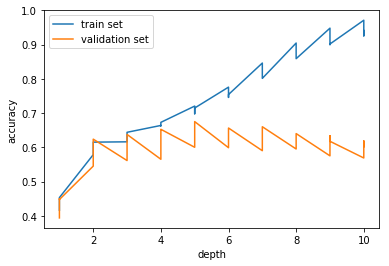

In [8]:
# Create a plot of the depth and accuracy values 
# with one curve for the training scores and one for the validation scores

# Plot validation curve
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(scores_df.dt__max_depth, scores_df.accuracy_tr, label = 'train set')
plt.plot(scores_df.dt__max_depth, scores_df.accuracy_val, label = 'validation set')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [9]:
# We can see that the model is overfitting when depth is greater than 5.

In [10]:
best = scores_df.sort_values(by='accuracy_val', ascending=False)[0:1]
print('Top accuracy on validation set:', best.iloc[0,1], ' with depth:', best.iloc[0,2])

Top accuracy on validation set: 0.675  with depth: 5


### Random forest classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create decision tree classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization
    ('pca', PCA(n_components=172)), # PCA preprocessing, number of components to retain 90% of the variance explained.
    ('rfc', RandomForestClassifier(random_state=0))
])

In [12]:
# grid of parameters 
grid = ParameterGrid({
    'scaler': [None, StandardScaler()],
    'pca' : [None, PCA(n_components=172)],
    'rfc__n_estimators': [50, 100, 200], # size of ensembles
    'rfc__max_depth' : [4,5,6]
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 36


In [13]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit on train set
    pipe.fit(X_tr2, y_tr2)
    
    # Save accuracy on train set
    params_dict['accuracy_tr'] = pipe.score(X_tr2, y_tr2)

    # Save accuracy on validation set
    params_dict['accuracy_val'] = pipe.score(X_val, y_val)
    
    # Save result
    test_scores.append(params_dict)

print('done')

Combination 1/36
Combination 2/36
Combination 3/36
Combination 4/36
Combination 5/36
Combination 6/36
Combination 7/36
Combination 8/36
Combination 9/36
Combination 10/36
Combination 11/36
Combination 12/36
Combination 13/36
Combination 14/36
Combination 15/36
Combination 16/36
Combination 17/36
Combination 18/36
Combination 19/36
Combination 20/36
Combination 21/36
Combination 22/36
Combination 23/36
Combination 24/36
Combination 25/36
Combination 26/36
Combination 27/36
Combination 28/36
Combination 29/36
Combination 30/36
Combination 31/36
Combination 32/36
Combination 33/36
Combination 34/36
Combination 35/36
Combination 36/36
done


In [14]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by='accuracy_val', ascending=False).head(10)

,accuracy_tr,accuracy_val,pca,rfc__max_depth,rfc__n_estimators,scaler
16,0.912813,0.78375,None,6,200,None
17,0.912813,0.78375,None,6,200,"StandardScaler(copy=True, with_mean=True, with..."
14,0.910312,0.78250,None,6,100,None
15,0.910312,0.78250,None,6,100,"StandardScaler(copy=True, with_mean=True, with..."
10,0.866563,0.77500,None,5,200,None
11,0.866563,0.77500,None,5,200,"StandardScaler(copy=True, with_mean=True, with..."
35,0.883125,0.77125,"PCA(copy=True, iterated_power='auto', n_compon...",6,200,"StandardScaler(copy=True, with_mean=True, with..."
8,0.865625,0.76875,None,5,100,None
9,0.865625,0.76875,None,5,100,"StandardScaler(copy=True, with_mean=True, with..."
4,0.823438,0.76750,None,4,200,None


#### Finally, fit your (tuned) decision tree and random forest estimators on the entire train set with 4,000 data points and evaluate them on the test set. Print the accuracy values.

In [15]:
# Create decision tree classifier with tuned parameters
pipe_dt_best = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=172)), 
    ('dt', DecisionTreeClassifier(max_depth = 5, criterion='gini', random_state=0))
])

# Fit it to the entire train data
pipe_dt_best.fit(X_tr, y_tr)

# evaluate its accuracy on the test set
accuracy_dt_best = pipe_dt_best.score(X_te, y_te)
print ('Decision tree classifier accuracy on the test set: {:.3f}'.format(accuracy_dt_best))

Decision tree classifier accuracy on the test set: 0.657


In [16]:
# Create random forest classifier with tuned parameters
pipe_rfc_best = Pipeline([
    ('scaler', None), # Without standardization
    ('pca', None), 
    ('rfc', RandomForestClassifier(n_estimators = 200, max_depth = 6, random_state=0))
])

# Fit it to the entire train data
pipe_rfc_best.fit(X_tr, y_tr)

# evaluate its accuracy on the test set
accuracy_rfc_best = pipe_rfc_best.score(X_te, y_te)
print ('Random forest classifier accuracy on the test set: {:.3f}'.format(accuracy_rfc_best))

Random forest classifier accuracy on the test set: 0.779
